In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, KFold, learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV

import os
from joblib import dump, load

## Import du dataset

In [2]:
mnist = np.load("../data/mnist_prepared.npz")

In [3]:
X = mnist["X"]
Y = mnist["Y"]

### Train_test_split

In [4]:
def persistent_train_test_split(x, y, path, train_size):

    t_size = str(train_size).replace('.', '_')
    file_name = "MNIST_data_split" + '_' + t_size
    path_train_size = path + file_name
    
    if os.path.isfile(path_train_size):
        X_train, X_test, Y_train, Y_test = load(path_train_size)
        print("Le split a été importé avec succès")
    else :         
        X_train, X_test, Y_train, Y_test = train_test_split(
            x,
            y,
            train_size = train_size,   # On entraine sur 5% de notre dataset
            stratify = y,
            shuffle = True,
            random_state = 42
        )
        
        dump((X_train, X_test, Y_train, Y_test), path_train_size)
        print("Le split a été créé et importé avec succès")

    return X_train, X_test, Y_train, Y_test

In [5]:
BNB_path_data = "../data/"

X_train, X_test, Y_train, Y_test = persistent_train_test_split(X, Y, BNB_path_data, 0.05)

Le split a été créé et importé avec succès


In [6]:
X_train.shape

(3500, 784)

## Multinomial Naive Bayes model

In [7]:
BNB = BernoulliNB()

##### Fonction de sauvegarde de modèles entraînés

In [8]:
def dump_artefact(tuned_model, path_artefact : str, artefact_name : str):

    
    score = round(tuned_model.best_score_, 3)  # on arrondis le score à 3 décimales
    score = str(score).replace('.', '')
    name = artefact_name + '_' + score

    path = path_artefact + name
    if os.path.isfile(path):
        print(f"Le modèle {artefact_name} existe déjà")

    else :
        model = dump(tuned_model.best_estimator_, path)  # Si le modèle a déjà été crée précédemment, alors on l'importe
        print(f"L'artefact de {artefact_name} a été crée avec succès")
        

#### Recherche d'hyperparamètres n°1

In [15]:
param_grid_BNB1 = {
    'alpha' : np.abs(np.random.lognormal(0, 10, 300)),
    'binarize' : np.arange(1, 255, 54)
}

In [10]:
Grid_BNB1 = BayesSearchCV(
    estimator = BNB,
    search_spaces = param_grid_BNB1,
    n_iter = 20,
    scoring = 'accuracy',
    cv = KFold(n_splits = 4),
    verbose = 4,
    n_jobs = 10
)

In [11]:
Grid_BNB1.fit(X_train, Y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

,estimator,BernoulliNB()
,search_spaces,"{'alpha': array([4.2851...91107678e-13]), 'binarize': array([ 1, ...09, 163, 217])}"
,optimizer_kwargs,None
,n_iter,20
,scoring,'accuracy'
,fit_params,None
,n_jobs,10
,n_points,1
,iid,'deprecated'
,refit,True
,cv,KFold(n_split...shuffle=False)


In [12]:
print("Best params : ", Grid_BNB1.best_params_ )
print("Best score : ", Grid_BNB1.best_score_)

Best params :  OrderedDict({'alpha': 5.148370331463298e-05, 'binarize': 109})
Best score :  0.840857142857143


In [14]:
dump_artefact(
    tuned_model = Grid_BNB1,
    path_artefact = "../saved_models/BernoulliNB_persistent/",
    artefact_name = "BNB1"
)

L'artefact de BNB1 a été crée avec succès


#### Recherche d'hyperparamètres n°2

In [29]:
param_grid_BNB2 = {
    'alpha' : np.abs(np.random.lognormal(0, 5, 100)),
    'binarize' : np.arange(1, 255, 24)
}

In [34]:
Grid_BNB2 = BayesSearchCV(
    estimator = BNB,
    search_spaces = param_grid_BNB2,
    n_iter = 20,
    scoring = 'accuracy',
    cv = KFold(n_splits = 4),
    verbose = 4,
    n_jobs = 10
)

In [35]:
Grid_BNB2.fit(X_train, Y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

,estimator,BernoulliNB()
,search_spaces,"{'alpha': array([4.4608...29466426e+02]), 'binarize': array([ 1, ...93, 217, 241])}"
,optimizer_kwargs,None
,n_iter,20
,scoring,'accuracy'
,fit_params,None
,n_jobs,10
,n_points,1
,iid,'deprecated'
,refit,True
,cv,KFold(n_split...shuffle=False)


In [37]:
print("Best params : ", Grid_BNB2.best_params_ )
print("Best score : ", Grid_BNB2.best_score_)

Best params :  OrderedDict({'alpha': 0.2563424383129817, 'binarize': 1})
Best score :  0.8348571428571429


In [39]:
dump_artefact(
    tuned_model = Grid_BNB2,
    path_artefact = "../saved_models/BernoulliNB_persistent/",
    artefact_name = "BNB2"
)

L'artefact de BNB2 a été crée avec succès


#### Recherche d'hyperparamètres n°3

In [41]:
param_grid_BNB3 = {
    'alpha' : np.abs(np.random.lognormal(0, 1, 200)),
    'binarize' : np.arange(1, 255, 24)
}

In [42]:
Grid_BNB3 = BayesSearchCV(
    estimator = BNB,
    search_spaces = param_grid_BNB3,
    n_iter = 20,
    scoring = 'accuracy',
    cv = KFold(n_splits = 4),
    verbose = 4,
    n_jobs = 10
)

In [43]:
Grid_BNB3.fit(X_train, Y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

,estimator,BernoulliNB()
,search_spaces,"{'alpha': array([ 0.253... 0.45137058]), 'binarize': array([ 1, ...93, 217, 241])}"
,optimizer_kwargs,None
,n_iter,20
,scoring,'accuracy'
,fit_params,None
,n_jobs,10
,n_points,1
,iid,'deprecated'
,refit,True
,cv,KFold(n_split...shuffle=False)


In [44]:
print("Best params : ", Grid_BNB3.best_params_ )
print("Best score : ", Grid_BNB3.best_score_)

Best params :  OrderedDict({'alpha': 0.7963295910133046, 'binarize': 49})
Best score :  0.8368571428571429


In [45]:
dump_artefact(
    tuned_model = Grid_BNB3,
    path_artefact = "../saved_models/BernoulliNB_persistent/",
    artefact_name = "BNB3"
)

L'artefact de BNB3 a été crée avec succès


#### Recherche d'hyperparamètres n°4

In [46]:
param_grid_BNB4 = {
    'alpha' : np.arange(0, 1, 0.05),
    'binarize' : np.arange(1, 255, 24)
}

In [47]:
Grid_BNB4 = BayesSearchCV(
    estimator = BNB,
    search_spaces = param_grid_BNB4,
    n_iter = 20,
    scoring = 'accuracy',
    cv = KFold(n_splits = 4),
    verbose = 4,
    n_jobs = 10
)

In [48]:
Grid_BNB4.fit(X_train, Y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

,estimator,BernoulliNB()
,search_spaces,"{'alpha': array([0. , ..., 0.9 , 0.95]), 'binarize': array([ 1, ...93, 217, 241])}"
,optimizer_kwargs,None
,n_iter,20
,scoring,'accuracy'
,fit_params,None
,n_jobs,10
,n_points,1
,iid,'deprecated'
,refit,True
,cv,KFold(n_split...shuffle=False)


In [50]:
print("Best params : ", Grid_BNB4.best_params_ )
print("Best score : ", Grid_BNB4.best_score_)

Best params :  OrderedDict({'alpha': 0.2, 'binarize': 49})
Best score :  0.8391428571428571


In [99]:
dump_artefact(
    tuned_model = Grid_BNB4,
    path_artefact = "../saved_models/BernoulliNB_persistent/",
    artefact_name = "BNB4"
)

L'artefact de BNB4 a été crée avec succès


#### Recherche d'hyperparamètres n°5

In [76]:
param_grid_BNB5 = {
    'alpha' : np.abs(np.random.lognormal(0, 1, 200)),
    'binarize' : np.arange(1, 255, 24)
}

In [77]:
Grid_BNB5 = BayesSearchCV(
    estimator = BNB,
    search_spaces = param_grid_BNB5,
    n_iter = 30,
    scoring = 'accuracy',
    cv = KFold(n_splits = 4),
    verbose = 4,
    n_jobs = 10
)

In [78]:
Grid_BNB5.fit(X_train, Y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

,estimator,BernoulliNB()
,search_spaces,"{'alpha': array([ 1.892... 5.19563605]), 'binarize': array([ 1, ...93, 217, 241])}"
,optimizer_kwargs,None
,n_iter,30
,scoring,'accuracy'
,fit_params,None
,n_jobs,10
,n_points,1
,iid,'deprecated'
,refit,True
,cv,KFold(n_split...shuffle=False)


In [79]:
print("Best params : ", Grid_BNB5.best_params_ )
print("Best score : ", Grid_BNB5.best_score_)

Best params :  OrderedDict({'alpha': 0.15757005219372563, 'binarize': 49})
Best score :  0.8391428571428571


In [100]:
dump_artefact(
    tuned_model = Grid_BNB5,
    path_artefact = "../saved_models/BernoulliNB_persistent/",
    artefact_name = "BNB5"
)

L'artefact de BNB5 a été crée avec succès


#### Recherche d'hyperparamètres n°6

In [95]:
param_grid_BNB6 = {
    'alpha' : np.abs(np.random.lognormal(0, 1, 100)),
    'binarize' : np.abs(np.random.normal(70, 25, 100))
}

In [96]:
Grid_BNB6 = BayesSearchCV(
    estimator = BNB,
    search_spaces = param_grid_BNB6,
    n_iter = 20,
    scoring = 'accuracy',
    cv = KFold(n_splits = 3),
    verbose = 4,
    n_jobs = 11
)

In [97]:
Grid_BNB6.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

,estimator,BernoulliNB()
,search_spaces,"{'alpha': array([ 0.616... 1.21111419]), 'binarize': array([103.05... 60.93095621])}"
,optimizer_kwargs,None
,n_iter,20
,scoring,'accuracy'
,fit_params,None
,n_jobs,11
,n_points,1
,iid,'deprecated'
,refit,True
,cv,KFold(n_split...shuffle=False)


In [98]:
print("Best params : ", Grid_BNB6.best_params_ )
print("Best score : ", Grid_BNB6.best_score_)

Best params :  OrderedDict({'alpha': 0.06133738171149413, 'binarize': 53.65788908283098})
Best score :  0.8394332812531387


In [101]:
dump_artefact(
    tuned_model = Grid_BNB6,
    path_artefact = "../saved_models/BernoulliNB_persistent/",
    artefact_name = "BNB6"
)

L'artefact de BNB6 a été crée avec succès


#### Recherche d'hyperparamètres n°7

In [109]:
param_grid_BNB7 = {
    'alpha' : np.arange(0.01, 0.4, 0.04),
    'binarize' : [49, 53, 109, 140]
}

In [117]:
Grid_BNB7 = GridSearchCV(
    estimator = BNB,
    param_grid = param_grid_BNB7,
    scoring = 'accuracy',
    cv = KFold(n_splits = 3),
    verbose = 4,
    n_jobs = 11
)

In [118]:
Grid_BNB7.fit(X_train, Y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


,estimator,BernoulliNB()
,param_grid,"{'alpha': array([0.01, ..., 0.33, 0.37]), 'binarize': [49, 53, ...]}"
,scoring,'accuracy'
,n_jobs,11
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,4
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(0.05)


In [119]:
print("Best params : ", Grid_BNB7.best_params_ )
print("Best score : ", Grid_BNB7.best_score_)

Best params :  {'alpha': np.float64(0.05), 'binarize': 53}
Best score :  0.8397189139295169


In [130]:
dump_artefact(
    tuned_model = Grid_BNB7,
    path_artefact = "../saved_models/BernoulliNB_persistent/",
    artefact_name = "BNB7"
)

L'artefact de BNB7 a été crée avec succès


#### Recherche d'hyperparamètres n°8

In [133]:
np.random.seed(0)
param_grid_BNB8 = {
    'alpha' : np.arange(0.03, 0.05, 0.01),
    'binarize' : np.random.normal(53, 5, 30)
}

In [136]:
Grid_BNB8 = GridSearchCV(
    estimator = BNB,
    param_grid = param_grid_BNB8,
    scoring = 'accuracy',
    cv = KFold(n_splits = 3),
    verbose = 4,
    n_jobs = 11
)

In [128]:
Grid_BNB8.fit(X_train, Y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


,estimator,BernoulliNB()
,param_grid,"{'alpha': array([0.03, 0.04, 0.05]), 'binarize': array([61.820... 60.34679385])}"
,scoring,'accuracy'
,n_jobs,11
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,4
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(0.05)


In [129]:
print("Best params : ", Grid_BNB8.best_params_ )
print("Best score : ", Grid_BNB8.best_score_)

Best params :  {'alpha': np.float64(0.05), 'binarize': np.float64(51.97420868117099)}
Best score :  0.8400047915738851


In [131]:
dump_artefact(
    tuned_model = Grid_BNB8,
    path_artefact = "../saved_models/BernoulliNB_persistent/",
    artefact_name = "BNB8"
)

L'artefact de BNB8 a été crée avec succès


#### Recherche d'hyperparamètres n°9

In [137]:
np.random.seed(0)
param_grid_BNB9 = {
    'alpha' : np.random.normal(0.05, 1, 50),
    'binarize' : np.random.normal(52, 9, 50)
}

In [143]:
Grid_BNB9 = GridSearchCV(
    estimator = BNB,
    param_grid = param_grid_BNB9,
    scoring = 'accuracy',
    cv = KFold(n_splits = 3),
    verbose = 3,
    n_jobs = 11
)

In [ ]:
Grid_BNB9.fit(X_train, Y_train)

In [146]:
print("Best params : ", Grid_BNB9.best_params_ )
print("Best score : ", Grid_BNB9.best_score_)

Best params :  {'alpha': np.float64(0.09575851730144608), 'binarize': np.float64(36.46345657901491)}
Best score :  0.8411465873754276


In [147]:
dump_artefact(
    tuned_model = Grid_BNB9,
    path_artefact = "../saved_models/BernoulliNB_persistent/",
    artefact_name = "BNB9"
)

L'artefact de BNB9 a été crée avec succès


#### Train Score & Test_score

In [148]:
def best_model(path):
    biggest_score = 0
    best_model = ""
    for artefact_name in os.listdir(path):
        if artefact_name != ".ipynb_checkpoints":
            score = int(artefact_name[-4:])
            if score > biggest_score:
                biggest_score = score
                best_model = artefact_name
    path_best_model = path + best_model
    model = load(path_best_model)
    return model
            

In [165]:
Best_model = best_model("../saved_models/BernoulliNB_persistent/")

In [166]:
print("Train_set score : ", Best_model.score(X_train, Y_train))
print("Test_set score : ", Best_model.score(X_test, Y_test))

Train_set score :  0.8517142857142858
Test_set score :  0.8394135338345865


Les scores sur le train_set et le val_set sont très proches donc notre modèle n'est ni en underfitting, ni en overfitting. 

#### Learning Curve

In [167]:
N, train_scores, val_scores = learning_curve(Best_model, X_train, Y_train, train_sizes=np.linspace(0.1, 1, 40))

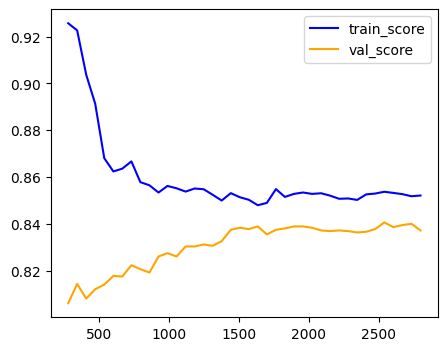

In [168]:
plt.figure(figsize=(5, 4))
plt.plot(N, train_scores.mean(axis=1), c='blue', label="train_score")
plt.plot(N, val_scores.mean(axis=1), c='orange', label="val_score")
plt.legend()

In [177]:
predictions = Best_model.predict(X_test)
confusion_matrix = confusion_matrix(predictions, Y_test)

[Text(0.5, 23.52222222222222, 'Predictions'),
 Text(50.722222222222214, 0.5, 'True values')]

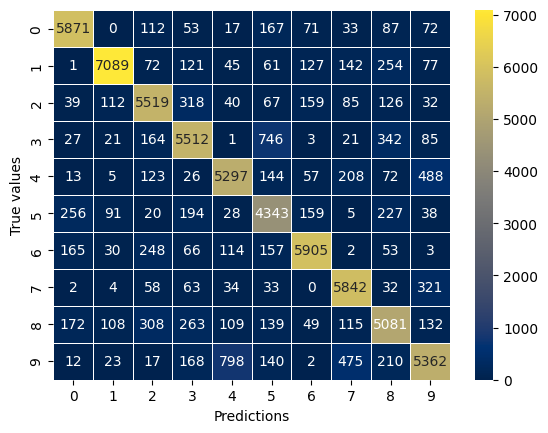

In [178]:
heatmap = sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap="cividis", linewidths=0.5)
heatmap.set(xlabel="Predictions", ylabel="True values")

#### Conclusion

Le modèle est globalement correct.  
Comme MultinomialNB, malgré une baisse de "l'accuracy" sur le jeu d'entraînement, au fur et à mesure que les données d'entraînement augmentent, on constate que l'écart diminue entre le score du training set et celui du validation set.  
On en conclue que le modèle n'a pas besoin de plus de données pour l'entraînement car les scores sur le training_set et le val_det convergent autour de 84% d'accuracy.  
De plus, le modèle capture assez bien les liens entre nos données en entrées et leur vraie valeur. Le modèle est Bayésien et naïf, donc il suppose une indépendance entre les features, ce qui n'est pas le cas, d'où un score inférieur à 90%
Peut-être qu'avec un meilleur traitement des données (Réduction de dimension, modification des valeurs des pixels des images etc...) ou une meilleure finesse dans la recherche des hyperparamètres on pourrait avoir un meilleur score.  